# Notebook for plotting SWLLIP geochornology data in context of MCR dates

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import pandas as pd

%matplotlib inline

## make python functions

In [2]:
def plot_dates(zircon_means, zircon_2sigmas, include, 
               sample_means, sample_2sigmas, colors, labels,
               legend=True, figsize=None, ylim=None, lineweight=None, 
               bbox_to_anchor=None, plot_zircons=True):
    """
    Make a date distribution plot.
    
    inputs:
    - zircon_means = list of numpy arrays containing mean dates (each array being a sample)
    - zircon_2sigmas = list of numpy arrays containing 2sigmas (each array being a sample)
    - include = list of 'yes' or 'no' array for inclusion in mean (each array being a sample)
    - sample_means = list of sample mean dates (one per sample)
    - sample_2sigmas = list of sample 2sigmas (one per sample)
    - colors = list of colors (one per sample)
    - labels = list of labels (one per sample)
    - figsize = figure size (optional)
    - ylim = ylim (optional)
    - linewidth = zircon linewidth (optional)
    - bbox_to_anchor = for the legend (optional)
    """
    # formatting constants
    zircon_spacing = 0.9
    sample_spacing = 5.75 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    x_positions = []
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    if plot_zircons == False:
        for i in range(n_samples):
            sample_width = 20

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)
            
            current_x = current_x + 25
        
    if plot_zircons == True:
        # iterate over each sample
        for i in range(n_samples):

            # number of zircons in sample
            n_zircons = len(zircon_means[i])

            # sample width
            sample_width = zircon_spacing*n_zircons

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)

            # legend control
            marked = False

            # iterate over each zircon
            for j in range(n_zircons):

                if marked:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha)
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)
                else:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                        marked = True
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)

                # tick the x to the next zircon
                current_x = current_x + zircon_spacing

            # tick the x to the next sample
            current_x = current_x + sample_spacing
            x_positions.append(current_x-sample_spacing)
    
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('$^{206}$Pb/$^{238}$U date (Ma)',fontsize=13)
    if legend == True:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax, x_positions

def read_data(header, nrows, path):
    return pd.read_excel(path, header=header,nrows=nrows,
                                        names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])

def weighted_mean(dates,sigma):
    
    """
    calculated a weighted mean from dates and uncertainities
    
    input parameters
    ----------------
    dates: date of individual grains
    sigma: 2σ uncertainty associated with dates
    
    returns
    ----------------
    weighted_mean, 2σ uncertainty
    
    """
    sigma = np.array(sigma)/2
    inverse_variance=[]
    alpha=[]
    weighted_mean_calc=[]
    
    for n in range(0,len(dates)):
        value = 1/sigma[n]**2
        inverse_variance.append(value)
    inverse_variance_sum = np.sum(inverse_variance)
    
    for n in range(0,len(dates)):
        value = (1/sigma[n]**2)/inverse_variance_sum
        alpha.append(value)
        
    #calculate the weights for each date    
    for n in range(0,len(dates)):
        value = alpha[n]*dates[n]
        weighted_mean_calc.append(value)
    
    #take the sum of the weights multiplied by the dates to get the weighted
    #mean (equation 64 of McLean et al., 2011)
    weighted_mean = np.sum(weighted_mean_calc)
    
    #the variance of the weighted mean is simply the inverse of the sum of
    #the inverse variances of each date (equation 66 of McLean et al., 2011)
    variance = 1/inverse_variance_sum
    
    weighted_mean_sigma = np.sqrt(variance)
    
    n = len(dates)
    
    # print('The weighted mean is:')

    # print(weighted_mean)

    # print('With a 2sigma error of:')

    # print(weighted_mean_sigma)
    
    # print('N=' )
    # print(n)
    
    return weighted_mean, 2*weighted_mean_sigma

## Import Duluth Complex geochronology and the upper southwest sequence of the North Shore Volcanic Group (7900 m thick)

Swanson-Hysell, N.L., Hoaglund, S.A., Crowley, J.L., Schmitz, M.D., Zhang, Y.*, and Miller Jr., J.D. (2021), **Rapid emplacement of massive Duluth Complex intrusions within the Midcontinent Rift**, *Geology*, doi:10.1130/G47873.1.

Swanson-Hysell, N.L., Ramenzani, J., Fairchild, L.M. and Rose, I., 2019, **Failed rifting and fast drifting: Midcontinent Rift development, Laurentia's rapid motion and the driver of Grenvillian orogenesis**, *Geological Society of America Bulletin*, doi:10.1130/B31944.1.

In [3]:
# PRI (Partridge River intrusion augite troctolite)
PRI = read_data(6, 6, path='../data/geochron/Swanson-Hysell2021a.xls')
PRI['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes'])
PRI_mean, PRI_2sigma = weighted_mean(PRI['206Pb/238U_date'].tolist(),PRI['206Pb/238U_date_2sigma'].tolist())

# FC4b (Forest Center gabbroic anorthosite)
FC_4b = read_data(16, 8, path='../data/geochron/Swanson-Hysell2021a.xls') 
FC_4b['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','no'])
FC_4b_filtered = FC_4b[FC_4b['include'] == 'yes']
FC4b_mean, FC4b_2sigma = weighted_mean(FC_4b_filtered['206Pb/238U_date'].tolist(),FC_4b_filtered['206Pb/238U_date_2sigma'].tolist())

# FC1 (Forest Center gabbroic anorthosite)
FC_1 = read_data(28, 10, path='../data/geochron/Swanson-Hysell2021a.xls') 
FC_1['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','yes','yes','yes','yes'])
FC1_mean, FC1_2sigma = weighted_mean(FC_1['206Pb/238U_date'].tolist(),FC_1['206Pb/238U_date_2sigma'].tolist())

# BEI (Bald Eagle intrusion olivine gabbro)
BEI = read_data(42, 6, path='../data/geochron/Swanson-Hysell2021a.xls') 
BEI['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes'])
BEI_mean, BEI_2sigma = weighted_mean(BEI['206Pb/238U_date'].tolist(),BEI['206Pb/238U_date_2sigma'].tolist())

# HCT Houghtaling Creek troctolite augite troctolite
HCT = read_data(52, 11, path='../data/geochron/Swanson-Hysell2021a.xls') 
HCT['include'] = pd.Series(data=['yes','yes','yes','yes','no','no','no','no','no','no','no'])
HCT_filtered = HCT[HCT['include'] == 'yes']
HCT_mean, HCT_2sigma = weighted_mean(HCT_filtered['206Pb/238U_date'].tolist(),HCT_filtered['206Pb/238U_date_2sigma'].tolist())


CA-ID-TIMS data from Midcontinent Rift volcanics were published in Fairchild et al. 2017 and Swanson-Hysell et al. 2019

Fairchild, L. M., Swanson-Hysell, N. L., Ramezani, J., Sprain, C. J., and Bowring, S. A., 2017, The end of Midcontinent Rift magmatism and the paleogeography of Laurentia: Lithosphere, vol. 9, pp. 117–133, doi:10.1130/L580.1.

Swanson-Hysell, N. L., Ramezani, J., Fairchild, L. M., and Rose, I. R., 2019, Failed rifting and fast drifting: Midcontinent Rift development, Laurentia’s rapid motion and the driver of Grenvillian orogenesis: GSA Bulletin, doi:10.1130/b31944.1.

In [4]:
AS3 = pd.read_csv('../data/geochron/AS3_dates.csv')
AS3.sort_values('206Pb/238U', inplace=True, ascending=False)
AS3.reset_index(inplace=True)
AS3_mean, AS3_2sigma = weighted_mean(AS3['206Pb/238U_date'].tolist(),AS3['206Pb/238U_date_2sigma'].tolist())

NSVG_40I = pd.read_csv('../data/geochron/NSVG-40I_dates.csv')
NSVG_40I.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_40I.reset_index(inplace=True)
NSVG_40I_mean, NSVG_40I_2sigma = weighted_mean(NSVG_40I['206Pb/238U'].tolist(), NSVG_40I['206Pb/238U_2sigma'].tolist())

NSVG_TH1 = pd.read_csv('../data/geochron/NSVG-TH1_dates.csv')
NSVG_TH1.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_TH1.reset_index(inplace=True)
NSVG_TH1_mean, NSVG_TH1_2sigma = weighted_mean(NSVG_TH1['206Pb/238U'].tolist(), NSVG_TH1['206Pb/238U_2sigma'].tolist())

NSVG_PR = pd.read_csv('../data/geochron/NSVG-PR_dates.csv')
NSVG_PR.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_PR.reset_index(inplace=True)
NSVG_PR_mean, NSVG_PR_2sigma = weighted_mean(NSVG_PR['206Pb/238U'].tolist(), NSVG_PR['206Pb/238U_2sigma'].tolist())

## Load geochronology data from Mohr et al., 2023

In [5]:
# F2020 Warm Spring Canyon mafic sill 
F2020 = read_data(4, 8, path='../data/geochron/Mohr2023a.xlsx') 
F2020['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','yes'])
F2020_mean, F2020_2sigma = weighted_mean(F2020['206Pb/238U_date'].tolist(),F2020['206Pb/238U_date_2sigma'].tolist())

# CS4 Warm Spring Canyon mafic sill 
CS4 = read_data(13, 9, path='../data/geochron/Mohr2023a.xlsx')
CS4['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','yes','yes'])
CS4_mean, CS4_2sigma = weighted_mean(CS4['206Pb/238U_date'].tolist(),CS4['206Pb/238U_date_2sigma'].tolist())

# CS7 Ibex Range mafic sill
CS7 = read_data(23, 5, path='../data/geochron/Mohr2023a.xlsx')
CS7['include'] = pd.Series(data=['no','yes','yes','yes','yes'])
CS7_filtered = CS7[CS7['include'] == 'yes']
CS7_mean, CS7_2sigma = weighted_mean(CS7_filtered['206Pb/238U_date'].tolist(),CS7_filtered['206Pb/238U_date_2sigma'].tolist())

# MM2021_CA1 Dead Mountains mafic sill
MM2021_CA1 = read_data(29, 16, path='../data/geochron/Mohr2023a.xlsx')
MM2021_CA1['include'] = pd.Series(data=['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes','yes','yes','yes','yes','yes', 'yes', 'yes'])
MM2021_CA1_filtered = MM2021_CA1[MM2021_CA1['include'] == 'yes']
MM2021_CA1_mean, MM2021_CA1_2sigma = weighted_mean(MM2021_CA1_filtered['206Pb/238U_date'].tolist(),MM2021_CA1_filtered['206Pb/238U_date_2sigma'].tolist())

# K12_132L Grand Canyon diabase sill
K12_132L = read_data(46, 15, path='../data/geochron/Mohr2023a.xlsx')
K12_132L['include'] = pd.Series(data=['no', 'no', 'no', 'no', 'no', 'no', 'yes','yes','yes','yes','yes','yes', 'yes', 'yes', 'yes'])
K12_132L_filtered = K12_132L[K12_132L['include'] == 'yes']
K12_132L_mean, K12_132L_2sigma = weighted_mean(K12_132L_filtered['206Pb/238U_date'].tolist(),K12_132L_filtered['206Pb/238U_date_2sigma'].tolist())

# MS17_107 Grand Canyon diabase sill
MS17_107 = read_data(62, 7, path='../data/geochron/Mohr2023a.xlsx')
MS17_107['include'] = pd.Series(data=['yes','yes','yes','yes', 'no', 'no', 'no'])
MS17_107_filtered = MS17_107[MS17_107['include'] == 'yes']
MS17_107_mean, MS17_107_2sigma = weighted_mean(MS17_107_filtered['206Pb/238U_date'].tolist(),MS17_107_filtered['206Pb/238U_date_2sigma'].tolist())

# MM21_R52 Cardenas Basalt
MM21_R52 = read_data(70, 7, path='../data/geochron/Mohr2023a.xlsx')
MM21_R52['include'] = pd.Series(data=['no', 'no', 'no', 'yes','yes','yes','yes'])
MM21_R52_filtered = MM21_R52[MM21_R52['include'] == 'yes']
MM21_R52_mean, MM21_R52_2sigma = weighted_mean(MM21_R52_filtered['206Pb/238U_date'].tolist(),MM21_R52_filtered['206Pb/238U_date_2sigma'].tolist())

# JT19_AA central Arizona diabase sill
JT19_AA = read_data(78, 13, path='../data/geochron/Mohr2023a.xlsx')
JT19_AA['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','yes','yes','yes','yes','yes','yes'])
JT19_AA_mean, JT19_AA_2sigma = weighted_mean(JT19_AA['206Pb/238U_date'].tolist(),JT19_AA['206Pb/238U_date_2sigma'].tolist())

In [6]:
U_Pb_zircon_dates = [NSVG_40I['206Pb/238U'].tolist(),
                    NSVG_TH1['206Pb/238U'].tolist(),
                    NSVG_PR['206Pb/238U'].tolist(),
                    AS3['206Pb/238U_date'].tolist(),
                    PRI['206Pb/238U_date'].tolist(),
                    BEI['206Pb/238U_date'].tolist(),
                    FC_1['206Pb/238U_date'].tolist(),
                    FC_4b['206Pb/238U_date'].tolist(),
                    HCT['206Pb/238U_date'].tolist(), 
                    F2020['206Pb/238U_date'].tolist(),
                    CS4['206Pb/238U_date'].tolist(),
                    CS7['206Pb/238U_date'].tolist(),
                    JT19_AA['206Pb/238U_date'].tolist(),
                    K12_132L['206Pb/238U_date'].tolist(),
                    MS17_107['206Pb/238U_date'].tolist(),
                    MM2021_CA1['206Pb/238U_date'].tolist(),
                    MM21_R52['206Pb/238U_date'].tolist(),]

U_Pb_zircon_2sigmas = [NSVG_40I['206Pb/238U_2sigma'].tolist(),
                      NSVG_TH1['206Pb/238U_2sigma'].tolist(),
                      NSVG_PR['206Pb/238U_2sigma'].tolist(),
                      AS3['206Pb/238U_date_2sigma'].tolist(),
                      PRI['206Pb/238U_date_2sigma'].tolist(),
                      BEI['206Pb/238U_date_2sigma'].tolist(),
                      FC_1['206Pb/238U_date_2sigma'].tolist(),
                      FC_4b['206Pb/238U_date_2sigma'].tolist(),
                      HCT['206Pb/238U_date_2sigma'].tolist(), 
                      F2020['206Pb/238U_date_2sigma'].tolist(),
                      CS4['206Pb/238U_date_2sigma'].tolist(),
                      CS7['206Pb/238U_date_2sigma'].tolist(),
                      JT19_AA['206Pb/238U_date_2sigma'].tolist(),
                      K12_132L['206Pb/238U_date_2sigma'].tolist(),
                      MS17_107['206Pb/238U_date_2sigma'].tolist(),
                      MM2021_CA1['206Pb/238U_date_2sigma'].tolist(),
                      MM21_R52['206Pb/238U_date_2sigma'].tolist()]

U_Pb_zircon_include = [NSVG_40I['include'].tolist(),
                       NSVG_TH1['include'].tolist(),
                       NSVG_PR['include'].tolist(),
                       AS3['include'].tolist(),
                       PRI['include'].tolist(),
                       BEI['include'].tolist(),
                       FC_1['include'].tolist(),
                       FC_4b['include'].tolist(),
                       HCT['include'].tolist(), 
                       F2020['include'].tolist(),
                       CS4['include'].tolist(),
                       CS7['include'].tolist(),
                       JT19_AA['include'].tolist(),
                       K12_132L['include'].tolist(),
                       MS17_107['include'].tolist(),
                       MM2021_CA1['include'].tolist(),
                       MM21_R52['include'].tolist()]

U_Pb_sample_means = [NSVG_40I_mean,
                     NSVG_TH1_mean, 
                     NSVG_PR_mean,
                     AS3_mean,
                     PRI_mean,
                     BEI_mean,
                     FC1_mean,
                     FC4b_mean,
                     HCT_mean, 
                     F2020_mean,
                     CS4_mean,
                     CS7_mean,
                     JT19_AA_mean,
                     K12_132L_mean,
                     MS17_107_mean,
                     MM2021_CA1_mean,
                     MM21_R52_mean]

U_Pb_sample_2sigmas = [NSVG_40I_2sigma,
                       NSVG_TH1_2sigma, 
                       NSVG_PR_2sigma, 
                       AS3_2sigma,
                       PRI_2sigma,
                       BEI_2sigma,
                       FC1_2sigma,
                       FC4b_2sigma,
                       HCT_2sigma, 
                       F2020_2sigma,
                       CS4_2sigma,
                       CS7_2sigma,
                       JT19_AA_2sigma,
                       K12_132L_2sigma,
                       MS17_107_2sigma,
                       MM2021_CA1_2sigma,
                       MM21_R52_2sigma]

colors = ['blue',
          'blue',
          'blue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue', 
          'brown',
          'brown',
          'brown',
          'brown',
          'brown',
          'brown',
          'orange', 
          'orange']

labels = ['40th Ave Icelandite',
          'Two Harbors Icelandite',
          'Palisade Rhyolite',
          'Duluth area anorthositic series (AS3)',
          'Partridge River intrusion',
          'Bald Eagle intrusion',
          'Forest Center anorthositic series (FC-1)',
          'Forest Center anorthositic series (FC-4b)',
          'Houghtaling Creek troctolite', 
          'Warm Spring Canyon mafic sill F2020',
          'Warm Spring Canyon mafic sill CS4',
          'Ibex Range mafic sill CS7',
          'Salt River Canyon mafic sill JT19_AA',
          'Grand Canyon diabase sill K12_132L',
          'Grand Canyon diabase sill MS17_107', 
          'Dead Mountains mafic sill MM2021_CA1',
          'Cardenas Basalt MM21_R52']

In [7]:
geochron_data = pd.DataFrame({'labels': labels, 
                      'polarity_colors' : colors, 
                      'U_Pb_zircon_dates': U_Pb_zircon_dates, 
                      'U_Pb_zircon_2sigmas': U_Pb_zircon_2sigmas,
                      'U_Pb_zircon_include': U_Pb_zircon_include,
                      'U_Pb_sample_mean': U_Pb_sample_means,
                      'U_Pb_sample_2sigma': U_Pb_sample_2sigmas})

geochron_data['n'] = [i.count('yes') for i in geochron_data['U_Pb_zircon_include']]

# calculate 2sigma with student T test values
geochron_data['2sigma'] = geochron_data['U_Pb_sample_2sigma']/2*stats.t.isf(0.025,geochron_data['n']-1)

# geochron_data.to_csv('./code_output/compiled_geochron.csv')
# geochron_data = pd.read_csv('./code_output/compiled_geochron.csv')
geochron_data

,labels,polarity_colors,U_Pb_zircon_dates,U_Pb_zircon_2sigmas,U_Pb_zircon_include,U_Pb_sample_mean,U_Pb_sample_2sigma,n,2sigma
0,40th Ave Icelandite,blue,"[1098.58, 1097.46, 1097.18, 1096.88, 1096.81, ...","[2.72, 0.73, 0.95, 0.7, 0.8, 0.67, 0.64, 0.99]","[no, yes, yes, yes, yes, yes, yes, yes]",1096.768836,0.283839,7,0.347264
1,Two Harbors Icelandite,blue,"[1097.33, 1096.44, 1096.27, 1096.08, 1095.74]","[0.71, 0.57, 0.59, 0.7, 0.71]","[no, yes, yes, yes, yes]",1096.369245,0.289171,4,0.460135
2,Palisade Rhyolite,blue,"[1096.29, 1094.66, 1094.47, 1094.34, 1094.19, ...","[1.53, 0.69, 0.77, 0.7, 1.14, 1.09, 0.87, 0.49]","[no, yes, yes, yes, yes, yes, yes, yes]",1094.015606,0.273667,7,0.334819
3,Duluth area anorthositic series (AS3),darkblue,"[1096.23, 1096.09, 1095.97, 1095.94, 1095.8, 1...","[0.88, 0.58, 0.5, 0.49, 0.49, 0.49, 0.46, 0.57]","[yes, yes, yes, yes, yes, yes, yes, yes]",1095.862213,0.187112,8,0.221225
4,Partridge River intrusion,darkblue,"[1096.3692956957627, 1096.3411986087767, 1096....","[0.4540650746678668, 0.44939847012038203, 0.45...","[yes, yes, yes, yes, yes, yes]",1096.194915,0.188294,6,0.242012
5,Bald Eagle intrusion,darkblue,"[1096.1747761266788, 1096.0388091332786, 1095....","[0.4484241145264616, 0.45859332803922687, 0.48...","[yes, yes, yes, yes, yes, yes]",1095.884576,0.190780,6,0.245208
6,Forest Center anorthositic series (FC-1),darkblue,"[1096.2692620731762, 1096.190625997245, 1095.9...","[0.5108447698370121, 0.5053458354644664, 0.509...","[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",1095.806484,0.158034,10,0.178748
7,Forest Center anorthositic series (FC-4b),darkblue,"[1095.8461922193035, 1095.8358206391165, 1095....","[0.46875239873114355, 0.4659085093712412, 0.47...","[yes, yes, yes, yes, yes, yes, yes, no]",1095.689963,0.178937,7,0.218922
8,Houghtaling Creek troctolite,darkblue,"[1095.664310374369, 1095.613548461745, 1095.29...","[0.4670155927134175, 0.5158799382054571, 0.602...","[yes, yes, yes, yes, no, no, no, no, no, no, no]",1095.437962,0.258533,4,0.411384
9,Warm Spring Canyon mafic sill F2020,brown,"[1097.48, 1097.51, 1097.53, 1097.74, 1097.83, ...","[2.0, 0.97, 2.92, 0.53, 0.38, 0.65, 0.71, 2.07]","[yes, yes, yes, yes, yes, yes, yes, yes]",1097.907226,0.246188,8,0.291072


## Load geochronology data from Mohr et al., 2023

In [8]:
Mohr2023a_data = geochron_data.iloc[9:]
Mohr2023a_data = Mohr2023a_data.sort_values(by=['U_Pb_sample_mean']).reset_index(drop=True)
Mohr2023a_data


,labels,polarity_colors,U_Pb_zircon_dates,U_Pb_zircon_2sigmas,U_Pb_zircon_include,U_Pb_sample_mean,U_Pb_sample_2sigma,n,2sigma
0,Cardenas Basalt MM21_R52,orange,"[1027.73, 1032.34, 1062.17, 1081.99, 1082.13, ...","[0.7, 0.6, 1.96, 1.52, 1.08, 2.54, 2.5]","[no, no, no, yes, yes, yes, yes]",1082.178783,0.789297,4,1.255947
1,Dead Mountains mafic sill MM2021_CA1,orange,"[1013.49, 1047.39, 1049.98, 1052.64, 1054.89, ...","[0.65, 0.79, 0.67, 1.06, 0.72, 1.06, 0.71, 0.7...","[no, no, no, no, no, no, no, no, yes, yes, yes...",1082.602272,0.256704,8,0.303505
2,Warm Spring Canyon mafic sill F2020,brown,"[1097.48, 1097.51, 1097.53, 1097.74, 1097.83, ...","[2.0, 0.97, 2.92, 0.53, 0.38, 0.65, 0.71, 2.07]","[yes, yes, yes, yes, yes, yes, yes, yes]",1097.907226,0.246188,8,0.291072
3,Salt River Canyon mafic sill JT19_AA,brown,"[1097.77, 1097.77, 1097.78, 1097.85, 1098.0, 1...","[0.42, 0.28, 0.33, 0.3, 0.38, 0.47, 0.47, 0.3,...","[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",1098.036967,0.101099,13,0.110138
4,Ibex Range mafic sill CS7,brown,"[984.16, 1097.19, 1097.85, 1098.46, 1099.17]","[0.8, 1.31, 0.92, 1.08, 1.48]","[no, yes, yes, yes, yes]",1098.090740,0.569982,4,0.906968
5,Grand Canyon diabase sill K12_132L,brown,"[1024.25, 1027.21, 1051.65, 1044.98, 1051.78, ...","[2.18, 1.22, 1.29, 1.28, 1.78, 1.02, 0.65, 1.0...","[no, no, no, no, no, no, yes, yes, yes, yes, y...",1098.091367,0.297316,9,0.342806
6,Grand Canyon diabase sill MS17_107,brown,"[1097.68, 1097.99, 1098.33, 1098.42, 1212.13, ...","[1.04, 0.63, 0.88, 0.63, 0.69, 0.99, 1.12]","[yes, yes, yes, yes, no, no, no]",1098.160344,0.371264,4,0.590765
7,Warm Spring Canyon mafic sill CS4,brown,"[1097.97, 1098.0, 1098.16, 1098.32, 1098.38, 1...","[0.63, 0.64, 0.67, 0.64, 0.9, 0.72, 1.42, 0.63...","[yes, yes, yes, yes, yes, yes, yes, yes, yes]",1098.268309,0.232517,9,0.268093


### using Monte Carlo resample to estiamte the duration of the ca. 1098 Ma SWLLIP mafic magmatism

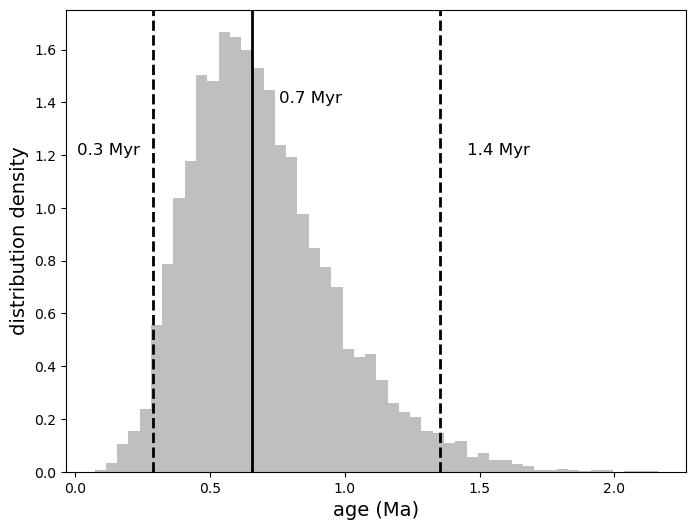

In [22]:
n_iteration = 10000
duration_list = []

for i in range(n_iteration):
    age_list = []
    for age, sigma in zip(Mohr2023a_data.iloc[2:]['U_Pb_sample_mean'], Mohr2023a_data.iloc[2:]['2sigma']/2):
        age_list.append(np.random.normal(age, sigma))
    duration_list.append(max(age_list)-min(age_list))

lower = np.percentile(duration_list, 2.5)
upper = np.percentile(duration_list, 97.5)
median = np.median(duration_list)

plt.figure(figsize=(8,6))
plt.hist(duration_list, bins=50, density=True, color='grey', alpha=0.5)
# plt.xlim(1099.5, 1097)
plt.axvline(lower, color='black', linestyle='--', linewidth=2)
plt.axvline(upper, color='black', linestyle='--', linewidth=2)
plt.axvline(median, color='black', linestyle='-', linewidth=2)
plt.text(lower-0.28, 1.2, str(round(lower,1))+' Myr', fontsize=12)
plt.text(upper+0.1, 1.2, str(round(upper,1))+' Myr', fontsize=12)
plt.text(median+0.1, 1.4, str(round(median,1))+' Myr', fontsize=12)


plt.xlabel('age (Ma)', fontsize=14)
plt.ylabel('distribution density', fontsize=14)
plt.savefig('../figure/SWLLIP_duration.pdf', bbox_inches='tight')
plt.show()

## Generate geochronology figure for manuscript

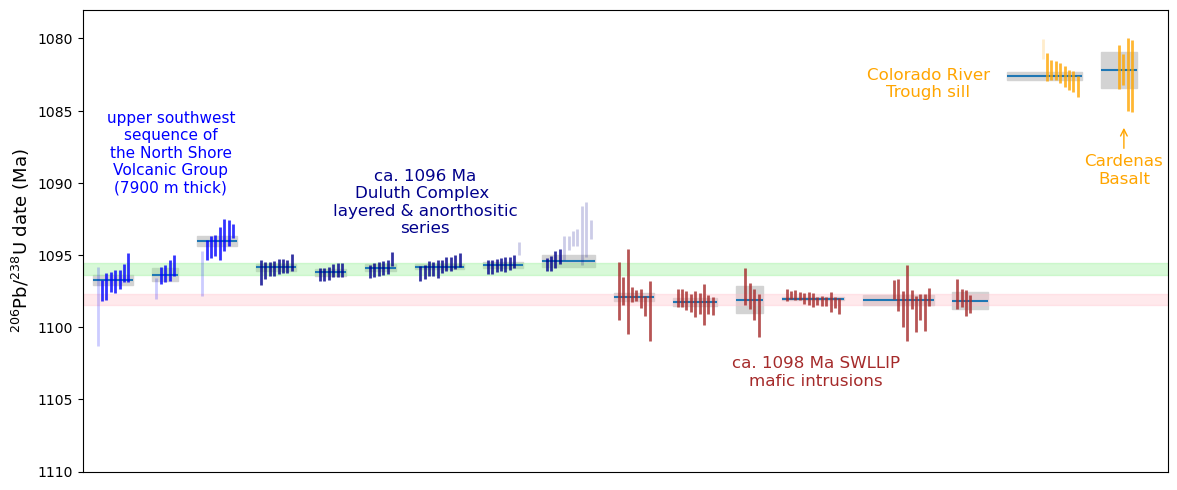

In [11]:
fig, ax, x_positions = plot_dates(geochron_data.U_Pb_zircon_dates, geochron_data.U_Pb_zircon_2sigmas, 
                                  geochron_data.U_Pb_zircon_include, 
                                  geochron_data.U_Pb_sample_mean, geochron_data['2sigma'], 
                                  colors, labels, legend=False, figsize=(14,6), lineweight=2)

# add Duluth Complex duration bar
rectangle = matplotlib.patches.Rectangle((0,1095.71 - 0.17),300, (1096.19 + 0.19)-(1095.71 - 0.17), color='lightgreen',alpha=0.35)
ax.add_patch(rectangle)

# add SWLLIP duration bar
rectangle = matplotlib.patches.Rectangle((0,1098.1 - 0.4), 300, 0.8, color='pink',alpha=0.35)
ax.add_patch(rectangle)

plt.text(18,1085,'upper southwest\nsequence of\nthe North Shore\nVolcanic Group\n(7900 m thick)',verticalalignment='top',
         horizontalalignment='center',fontsize=11, color='blue')
# plt.hlines(1090,3,x_positions[2], color='k')

plt.text(70, 1089, 'ca. 1096 Ma\nDuluth Complex \nlayered & anorthositic\nseries', color='darkblue' ,fontsize=12,
        verticalalignment='top',horizontalalignment='center')
# plt.hlines(1090,x_positions[2]+5,x_positions[8], color='k')

plt.text(150, 1102, 'ca. 1098 Ma SWLLIP\nmafic intrusions', color='brown' ,fontsize=12,
        verticalalignment='top',horizontalalignment='center')
# plt.hlines(1102,x_positions[8]+5,x_positions[14], color='k')

plt.text(173, 1082, 'Colorado River\nTrough sill', color='orange' ,fontsize=12,
        verticalalignment='top',horizontalalignment='center')

plt.annotate('Cardenas\nBasalt', (213, 1086), (213, 1088), color='orange' ,fontsize=12,
        verticalalignment='top',horizontalalignment='center', arrowprops={'arrowstyle':'->', 'color':'orange'})


plt.xlim(0, int(x_positions[-1])+7)
plt.xticks([])
plt.ylim(1110, 1078)
# plt.gca().invert_yaxis()
plt.ylabel('$^{206}$Pb/$^{238}$U date (Ma)',fontsize=13)
plt.savefig('../figure/SWLLIP_geochron.pdf', bbox_inches='tight')
plt.show()